In [1]:
import pandas as pd

import matplotlib.pyplot as plt
%config InlineBackend.figure_format = 'retina'

In [2]:
df = pd.read_csv('./ready_dataframe.csv')

In [4]:
df.isnull().sum()

mpg             0
cylinders       0
displacement    0
horsepower      0
weight          0
acceleration    0
model_year      0
origin          0
car_name        0
dtype: int64

In [5]:
df.dtypes

mpg             float64
cylinders         int64
displacement    float64
horsepower       object
weight          float64
acceleration    float64
model_year        int64
origin            int64
car_name         object
dtype: object

In [21]:
# seeing what's wrong with horsepower, it shouldn't be object
df['horsepower'].sort_values(ascending = False).head(10)

336        ?
32         ?
354        ?
374        ?
126        ?
330        ?
228    98.00
179    98.00
82     97.00
241    97.00
Name: horsepower, dtype: object

In [45]:
# what's the most repeated value?
df.loc[df['horsepower'] != '?', 'horsepower'].mode()

0    150.0
dtype: object

In [55]:
# clean up horsepower variable
df['horsepower'].replace('?', 150.0, inplace = True)

In [59]:
df['horsepower'] = df['horsepower'].astype('float')

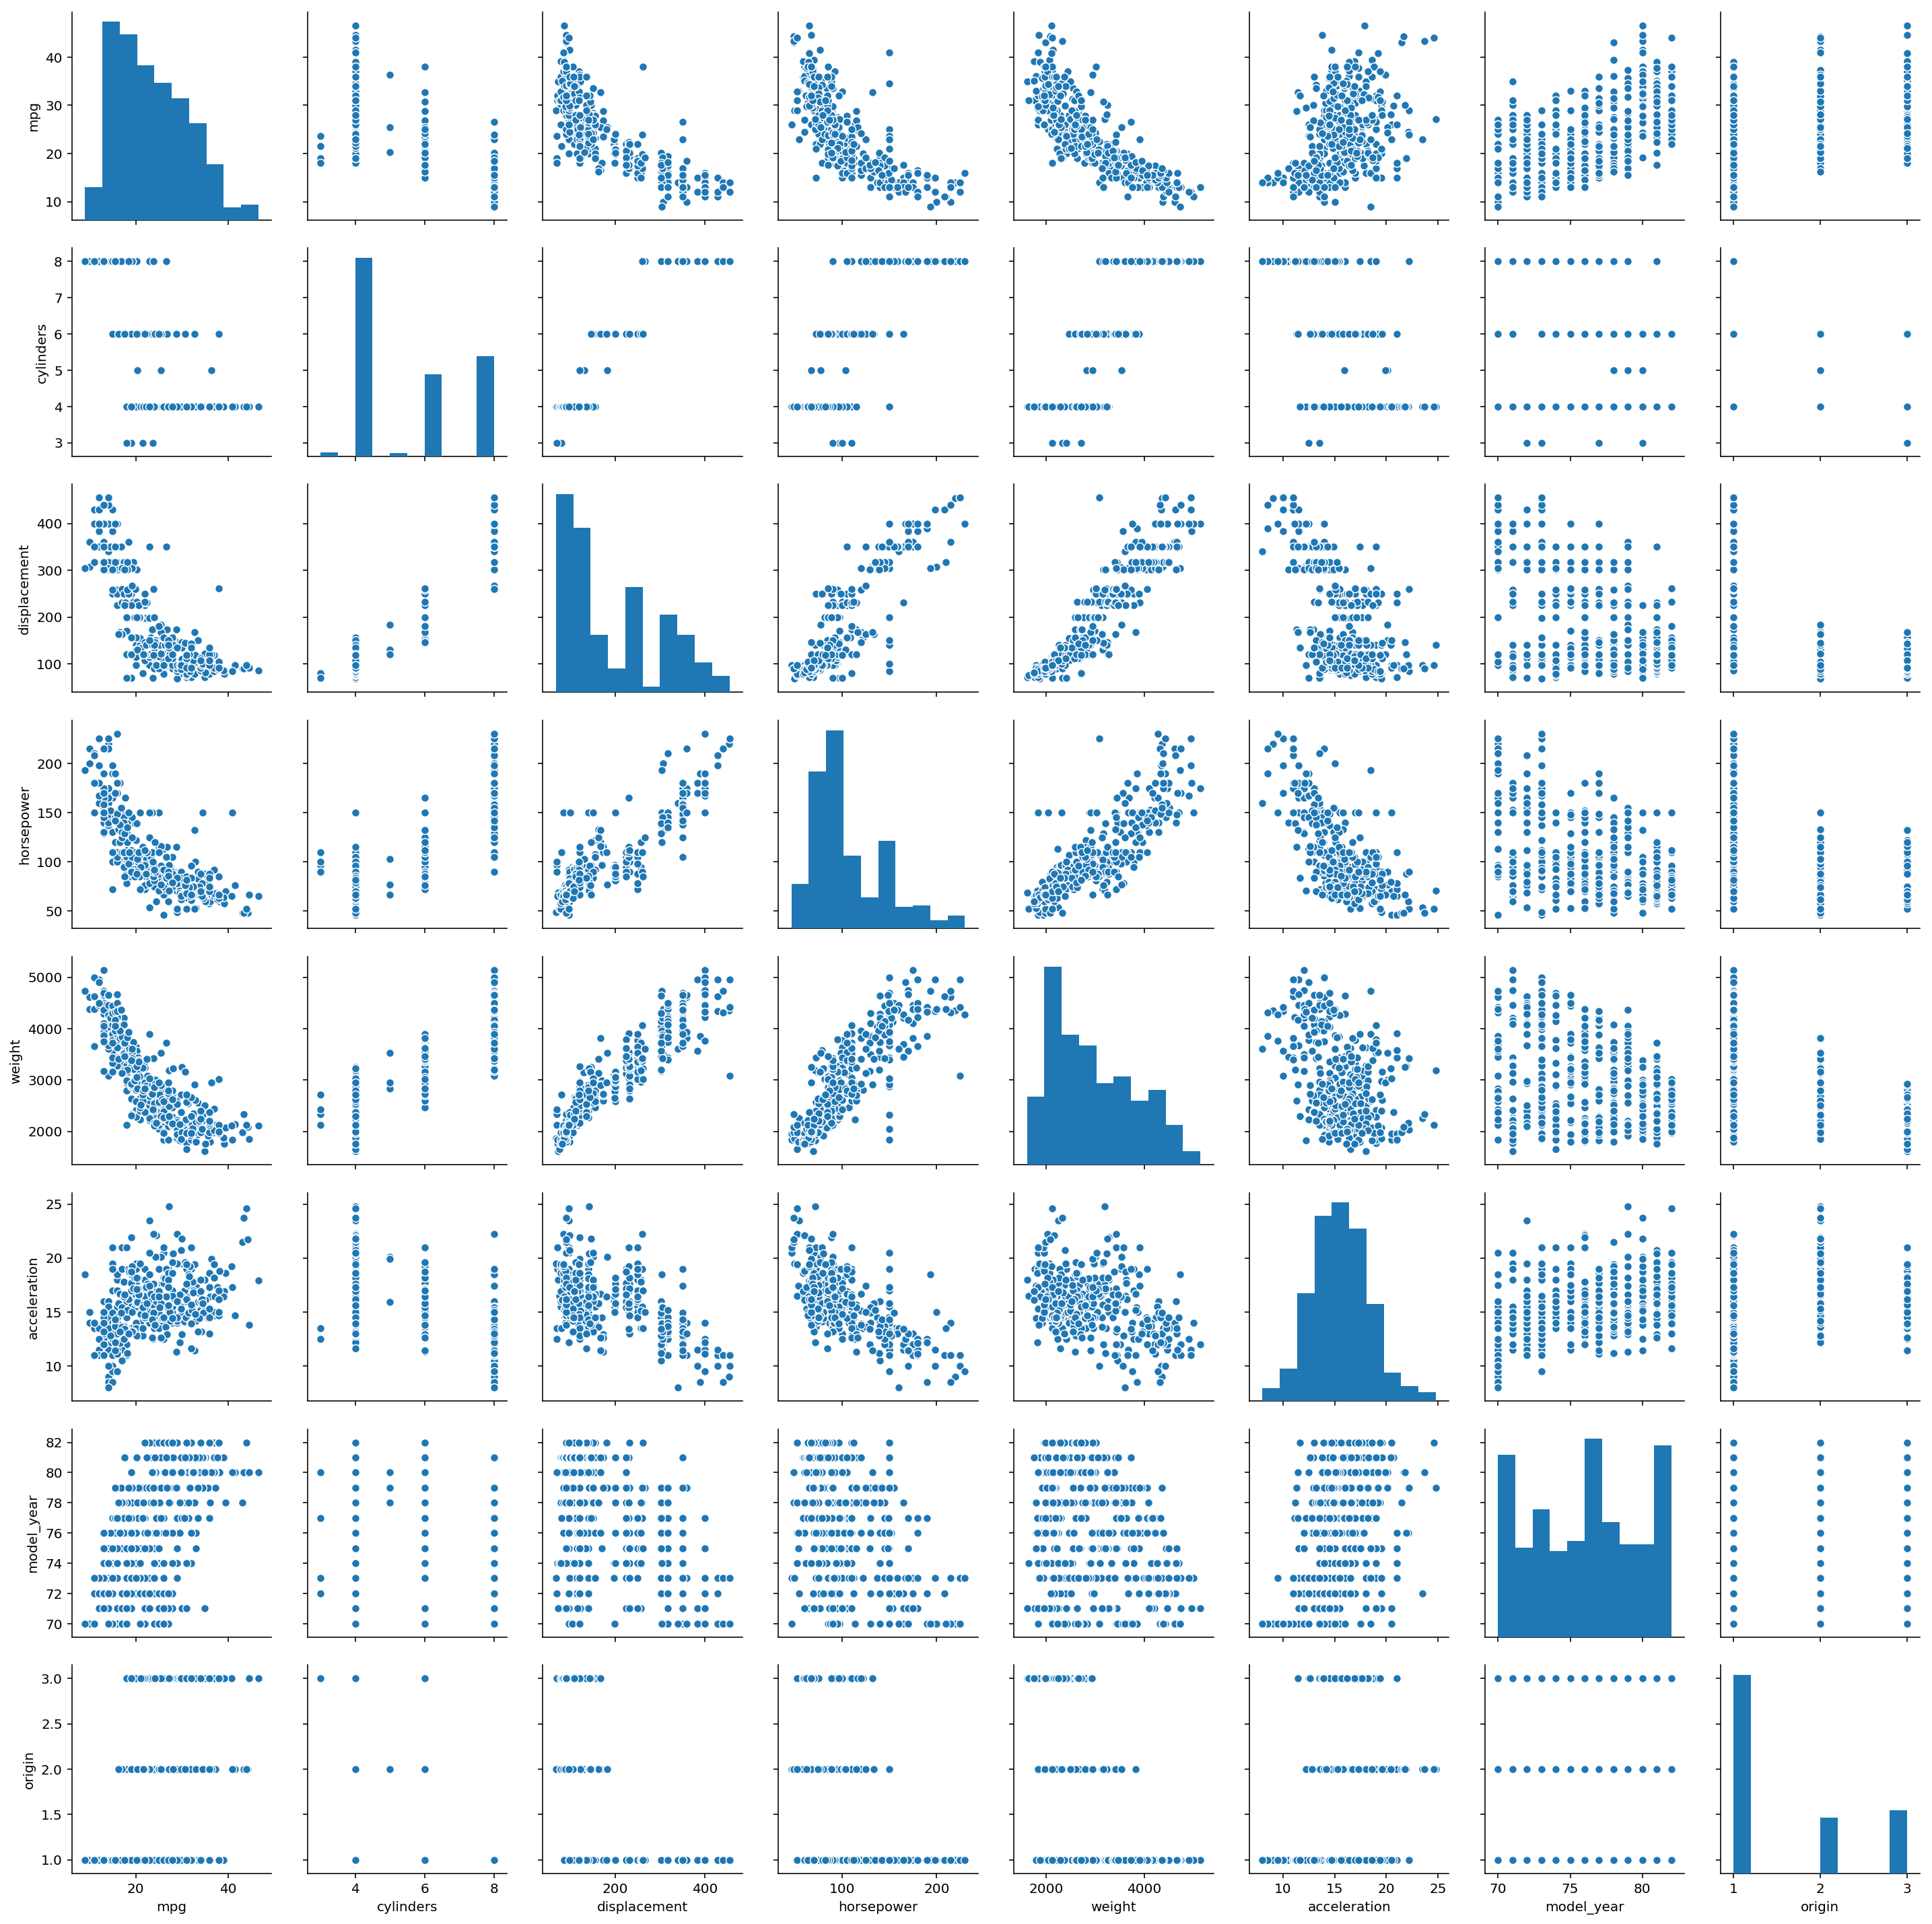

In [60]:
import seaborn as sns

sns.pairplot(df);

In [61]:
# correlations to mpg
corr = pd.DataFrame(df).corrwith(df['mpg'])
correlations = corr.to_frame(name = 'corrs')
correlations['abs_value'] = correlations['corrs'].abs()
correlations.sort_values(by = 'abs_value', ascending = False)

,corrs,abs_value
mpg,1.000000,1.000000
weight,-0.831741,0.831741
displacement,-0.804203,0.804203
cylinders,-0.775396,0.775396
horsepower,-0.753177,0.753177
model_year,0.579267,0.579267
origin,0.563450,0.563450
acceleration,0.420289,0.420289


In [62]:
def make_heat_map(df):
    """
    Plots the heatmap of correlations of the given df
    """
    import seaborn as sns
    import numpy as np

    mask = np.zeros_like(df.corr())
    mask[np.triu_indices_from(mask)] = True

    plt.figure(figsize = (8,8))

    cmap = sns.diverging_palette(220, 10, as_cmap=True)

    sns.heatmap(df.corr(), annot = True, mask = mask, vmin = -1, vmax = 1, cmap = cmap);

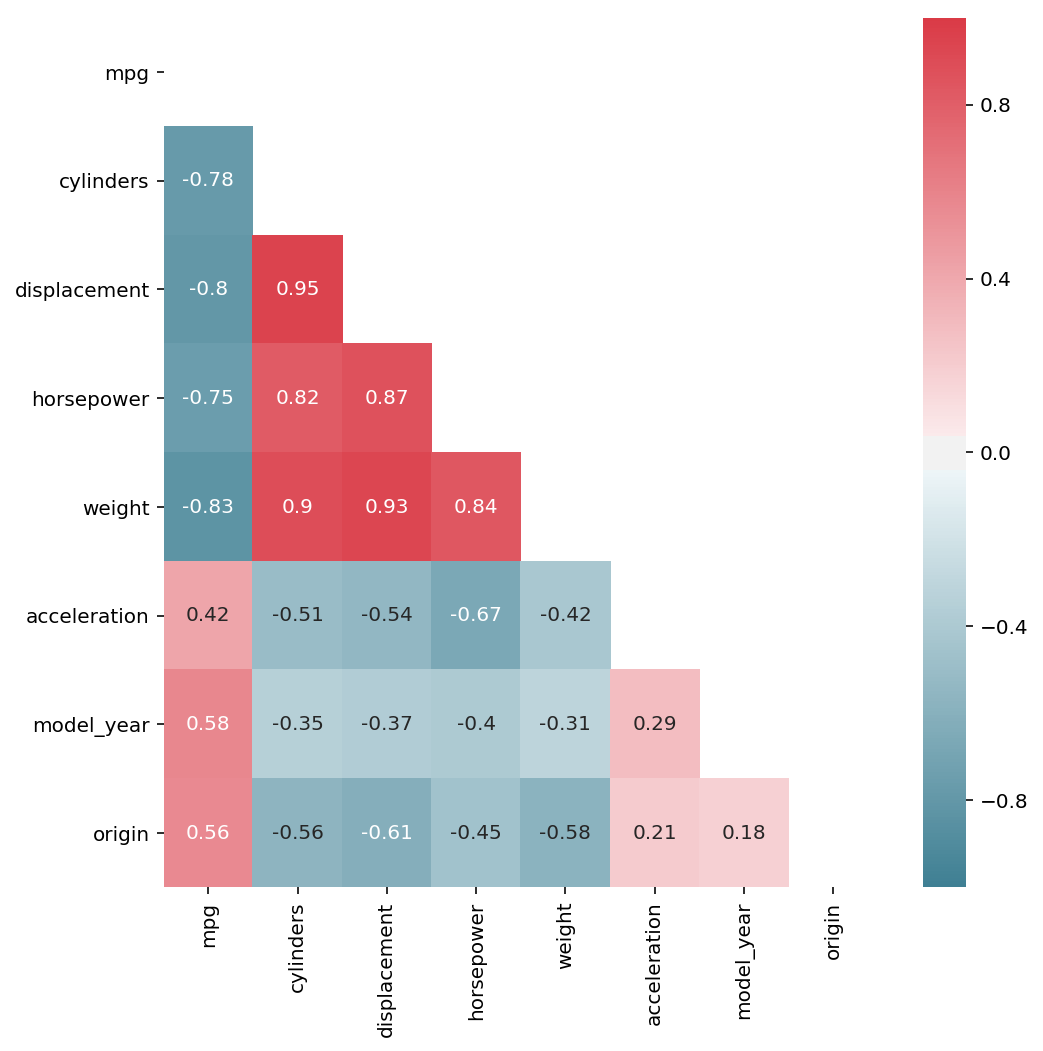

In [63]:
make_heat_map(df)

In [96]:
# how many models don't repeat in the dataset
df['car_name'].unique().shape

(305,)

<span style='color:navy'> General Observations: <br />
- More horsepower, less acceleration and less mpg
- More cylinders (and so more displacement), less mpg. Some negative effect on acceleration, not as strong as the one of horsepower, but close-ish.
- More weight, less mpg
- Better acceleration is (moderately) positively related with better mpg. </span>

<span style='color:purple'> **Thoughts on the metric** </span>
    
<span style='color:navy'> I can't say there could be one metric to give a quick evaluation of how "good" a car is. It depends what one means by good... Good for what and where? Is it good for off-roading? For city commute? For hauling stuff? For family?.. Is it good on gas? is it fast and accelerates great? is it reliable? is it comfortable? pretty? etc. Some of which variables we don't have access to in this dataset, which would be nice to have. There are many other variables I would like to access as well; like top speed, cost effectiveness (quantifiable by cost of maintenance, parts, initial price, special type of gas, etc.), reliability (quantifiable by how loyal are customers to this model? would they purchase it again? recommend it to a friend? how long before they buy their next car? etc). <br /> Along with other more subjective, yet quantifiable by field experts; like design, comfort, convenience (how often you need to fill up i.e. gas tank capacity, for one example). </span>
    
<span style='color:navy'> To keep this relevant to this dataset, I would say "good" here means good on gas, and accelerates well enough. </span>

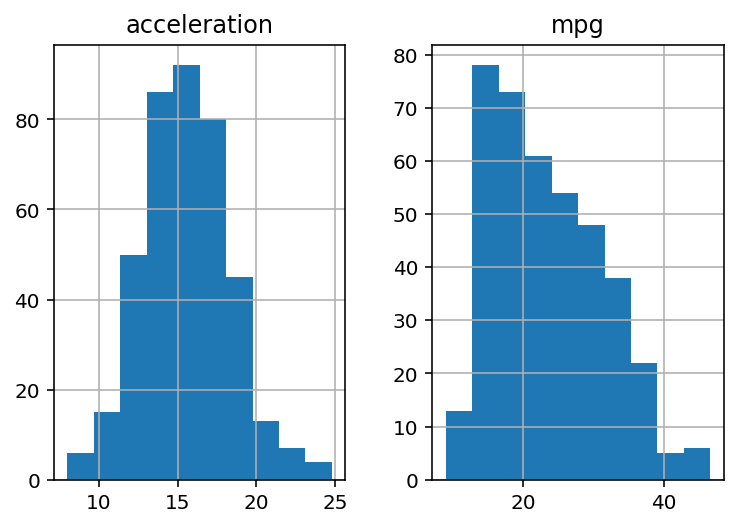

In [98]:
# to help with deciding on the metric
df[['mpg', 'acceleration']].hist();

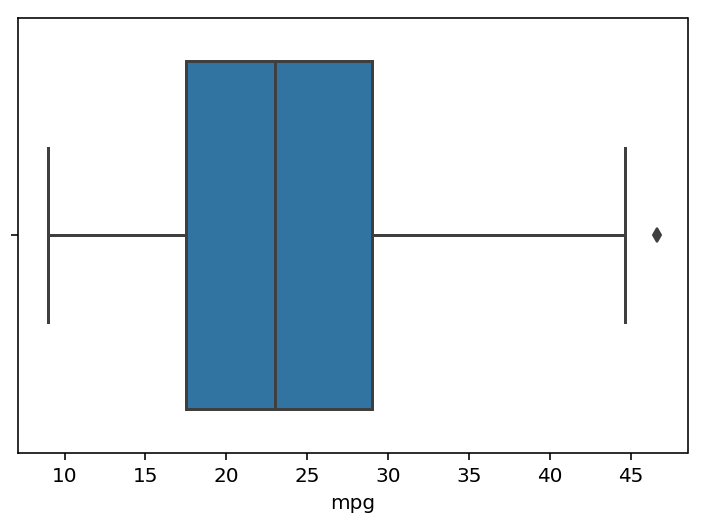

In [101]:
sns.boxplot(df['mpg']);

In [106]:
df.loc[df['mpg'] >= 46, :]

,mpg,cylinders,displacement,horsepower,weight,acceleration,model_year,origin,car_name
322,46.6,4,86.0,65.0,2110.0,17.9,80,3,mazda glc


In [105]:
print(df['mpg'].describe())
print(df['acceleration'].describe())

count    398.000000
mean      23.514573
std        7.815984
min        9.000000
25%       17.500000
50%       23.000000
75%       29.000000
max       46.600000
Name: mpg, dtype: float64
count    398.000000
mean      15.568090
std        2.757689
min        8.000000
25%       13.825000
50%       15.500000
75%       17.175000
max       24.800000
Name: acceleration, dtype: float64


<span style='color:purple'> **Building the metric** </span>

<span style='color:navy'>To make the score easy to understand by the public, and in order to disect it further, let's do the following:
- <span style='color:navy'> if a car in the top 25 percent on both mpg and acceleration, give it a rating of "great"
- <span style='color:navy'> between 50 and 75 on both: "good"
- <span style='color:navy'> between 25 and 50 on both: "acceptable"
- <span style='color:navy'> less than 25 on both: "bad"
    </span>

In [125]:
rough_score = []
for k in range(df.shape[0]):
    if (df['mpg'][k] >= 29) & (df['acceleration'][k] >= 17.175):
        rough_score.append("great")
        
    elif (df['mpg'][k] >= 23) & (df['mpg'][k] < 29) & (df['acceleration'][k] >= 15.50) & (df['acceleration'][k] < 17.175):
        rough_score.append("good")
        
    elif (df['mpg'][k] >= 17.5) & (df['mpg'][k] < 23) & (df['acceleration'][k] >= 13.825) & (df['acceleration'][k] < 15.50):
        rough_score.append("acceptable")
        
    else:
        rough_score.append("bad")

In [128]:
df['rough_score'] = rough_score

In [129]:
df.sample(10)

,mpg,cylinders,displacement,horsepower,weight,acceleration,model_year,origin,car_name,rough_score
155,15.0,6,250.0,72.0,3158.0,19.5,75,1,ford maverick,bad
51,30.0,4,79.0,70.0,2074.0,19.5,71,2,peugeot 304,great
81,28.0,4,97.0,92.0,2288.0,17.0,72,3,datsun 510 (sw),good
396,28.0,4,120.0,79.0,2625.0,18.6,82,1,ford ranger,bad
153,18.0,6,250.0,105.0,3459.0,16.0,75,1,chevrolet nova,bad
373,24.0,4,140.0,92.0,2865.0,16.4,82,1,ford fairmont futura,good
152,19.0,6,225.0,95.0,3264.0,16.0,75,1,plymouth valiant custom,bad
319,31.3,4,120.0,75.0,2542.0,17.5,80,3,mazda 626,great
91,13.0,8,400.0,150.0,4464.0,12.0,73,1,chevrolet caprice classic,bad
282,22.3,4,140.0,88.0,2890.0,17.3,79,1,ford fairmont 4,bad


In [130]:
df['rough_score'].value_counts()

bad           310
great          38
good           31
acceptable     19
Name: rough_score, dtype: int64

In [147]:
# the top 10 great cars, sorted by best on gas
df.loc[(df['mpg'] >= 29) & (df['acceleration'] >= 17.175), :][['car_name', 'model_year', 'mpg', 'acceleration']]. \
sort_values(by = ['mpg'], ascending = False).head(10)

,car_name,model_year,mpg,acceleration
322,mazda glc,80,46.6,17.9
325,vw rabbit c (diesel),80,44.3,21.7
394,vw pickup,82,44.0,24.6
326,vw dasher (diesel),80,43.4,23.7
244,volkswagen rabbit custom diesel,78,43.1,21.5
330,renault lecar deluxe,80,40.9,17.3
324,datsun 210,80,40.8,19.2
247,datsun b210 gx,78,39.4,18.6
310,toyota corolla tercel,80,38.1,18.8
348,toyota tercel,81,37.7,17.3


In [148]:
# the top 10 great cars, sorted by best acceleration
df.loc[(df['mpg'] >= 29) & (df['acceleration'] >= 17.175), :][['car_name', 'model_year', 'mpg', 'acceleration']]. \
sort_values(by = ['acceleration'], ascending = False).head(10)

,car_name,model_year,mpg,acceleration
394,vw pickup,82,44.0,24.6
326,vw dasher (diesel),80,43.4,23.7
195,chevrolet chevette,76,29.0,22.2
328,mercedes-benz 240d,80,30.0,21.8
325,vw rabbit c (diesel),80,44.3,21.7
244,volkswagen rabbit custom diesel,78,43.1,21.5
131,toyota corolla 1200,74,32.0,21.0
352,ford escort 2h,81,29.9,20.7
327,audi 5000s (diesel),80,36.4,19.9
360,volvo diesel,81,30.7,19.6


<span style='color:navy'> Is it mutually exclusive? Is it that cars having the best acceleration are not good on gas? <br />
We already saw, counter intuitively, better acceleration is actually moderately positively correlated with better miles per gallon. Below are the top 10 cars with respect to acceleration, to see how many of them are great on gas too. </span>

In [151]:
# Top 10 models with best acceleration over all are:
df.sort_values(by = 'acceleration', ascending = False).head(10)

,mpg,cylinders,displacement,horsepower,weight,acceleration,model_year,origin,car_name,rough_score
299,27.2,4,141.0,71.0,3190.0,24.8,79,2,peugeot 504,bad
394,44.0,4,97.0,52.0,2130.0,24.6,82,2,vw pickup,great
326,43.4,4,90.0,48.0,2335.0,23.7,80,2,vw dasher (diesel),great
59,23.0,4,97.0,54.0,2254.0,23.5,72,2,volkswagen type 3,bad
300,23.9,8,260.0,90.0,3420.0,22.2,79,1,oldsmobile cutlass salon brougham,bad
195,29.0,4,85.0,52.0,2035.0,22.2,76,1,chevrolet chevette,great
196,24.5,4,98.0,60.0,2164.0,22.1,76,1,chevrolet woody,bad
209,19.0,4,120.0,88.0,3270.0,21.9,76,2,peugeot 504,bad
328,30.0,4,146.0,67.0,3250.0,21.8,80,2,mercedes-benz 240d,great
325,44.3,4,90.0,48.0,2085.0,21.7,80,2,vw rabbit c (diesel),great


<span style='color:navy'> Good news, you don't need to sacrifice acceleration to get better gas milage, some of the fastest acceleration cars are good on gas too. <br />
Volks Wagon did very well with two of their models in the 80's. Chevy did well in 76 with the Chevette. <br />
That helps lifting off the fog a little. <br />
Looks like the main reason driving fuel effciency down is the horsepower, and weight. </span>